# Statistical methods in AI

## Assignment 2

### Problem 4.2:
### Joining bounding boxes

In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


In [156]:
df = pd.read_csv('CSV/TLBR_68.csv')
print(df.head())

   Unnamed: 0    Top-Left Bottom-Right  Id
0           0   [290, 85]   [435, 147]   0
1           1   [563, 82]   [730, 147]   1
2           2   [744, 92]   [940, 140]   2
3           3  [1163, 92]  [1184, 147]   3
4           4  [1218, 79]  [1344, 157]   4


In [157]:
img = cv2.imread('images/68.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [158]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(img_2)

In [159]:
def make_connections(image,euclidean):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

Let us take a look at how the bounding boxes look for the chosen image and its csv file.

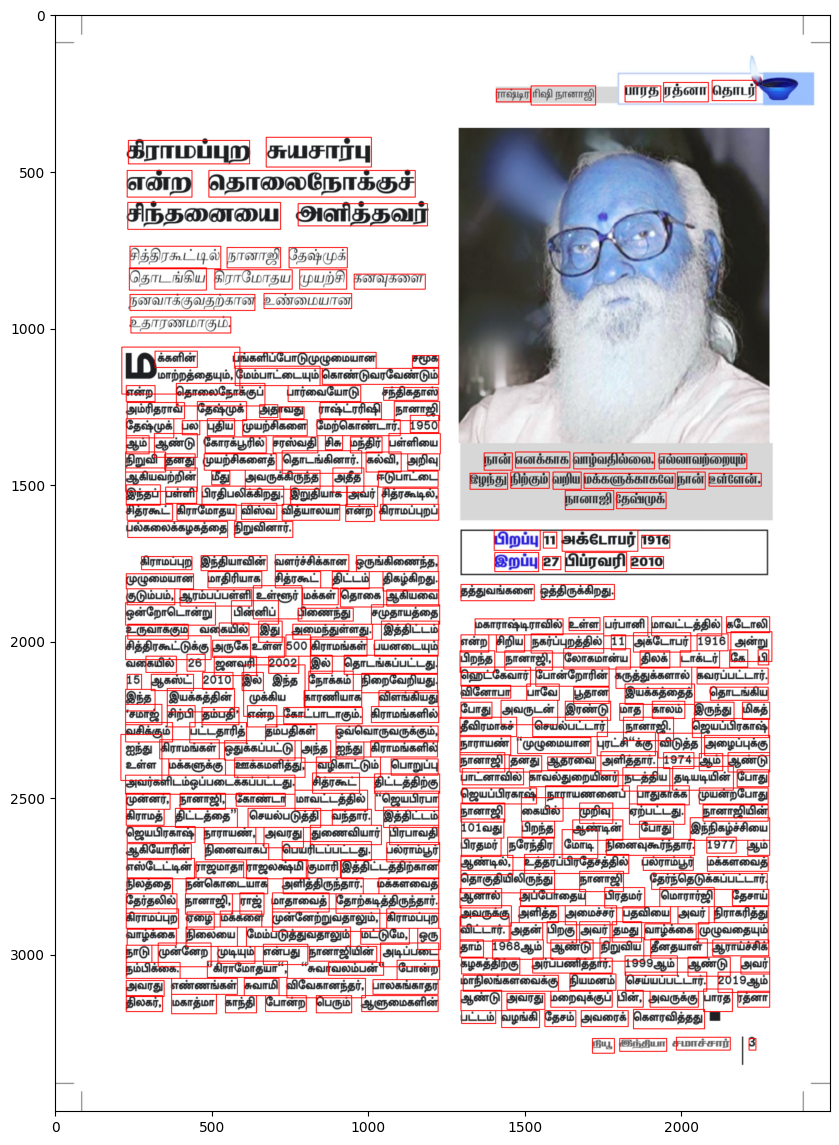

In [52]:
plt.figure(figsize = (10, 15))
visualize_bboxes(img)

So, now we shall compute the center, top edge, bottom edge, right edge and left edge coordinate values of every bounding box using the data given to us in the CSV file.

In [160]:
def get_centres(Top_left, bottom_right):
    centres = np.zeros((len(df), 2))

    for i in range(len(df)):
        x_coordinate = (Top_left[i][0] + bottom_right[i][0])//2
        y_coordinate = (Top_left[i][1] + bottom_right[i][1])//2

        centres[i][0] = x_coordinate
        centres[i][1] = y_coordinate

    return centres

def get_top_edge(top_left, bottom_right):
    top_edge = np.zeros((len(df), 2))

    for i in range(len(df)):
        x_coordinate = (top_left[i][0] + bottom_right[i][0])//2
        y_coordinate = top_left[i][1]

        top_edge[i][0] = x_coordinate
        top_edge[i][1] = y_coordinate

    return top_edge

def get_bottom_edge(top_left, bottom_right):
    bottom_edge = np.zeros((len(df), 2))

    for i in range(len(df)):
        x_coordinate = (top_left[i][0] + bottom_right[i][0])//2
        y_coordinate = bottom_right[i][1]

        bottom_edge[i][0] = x_coordinate
        bottom_edge[i][1] = y_coordinate

    return bottom_edge

def get_right_edge(top_left, bottom_right):
    right_edge = np.zeros((len(df), 2))

    for i in range(len(df)):
        x_coordinate =  bottom_right[i][0]
        y_coordinate = (bottom_right[i][1] + top_left[i][1])//2

        right_edge[i][0] = x_coordinate
        right_edge[i][1] = y_coordinate

    return right_edge


def get_left_edge(top_left, bottom_right):
    left_edge = np.zeros((len(df), 2))

    for i in range(len(df)):
        x_coordinate =  top_left[i][0]
        y_coordinate = (bottom_right[i][1] + top_left[i][1])//2

        left_edge[i][0] = x_coordinate
        left_edge[i][1] = y_coordinate

    return left_edge



In [161]:
Top_left = df['Top-Left'].apply(lambda x: ast.literal_eval(x))
bottom_right = df['Bottom-Right'].apply(lambda x: ast.literal_eval(x))

centres = get_centres(Top_left, bottom_right)
df['Top'] = get_top_edge(Top_left, bottom_right).tolist()
df['Bottom'] = get_bottom_edge(Top_left, bottom_right).tolist()
df['Right'] = get_right_edge(Top_left, bottom_right).tolist()
df['Left'] = get_left_edge(Top_left, bottom_right).tolist()

Making the dendrogram for the clustering. Our objective is to cluster these boxes such that we obtain boxes within the same paragraph whoch we can the use to obtain the threshold values.

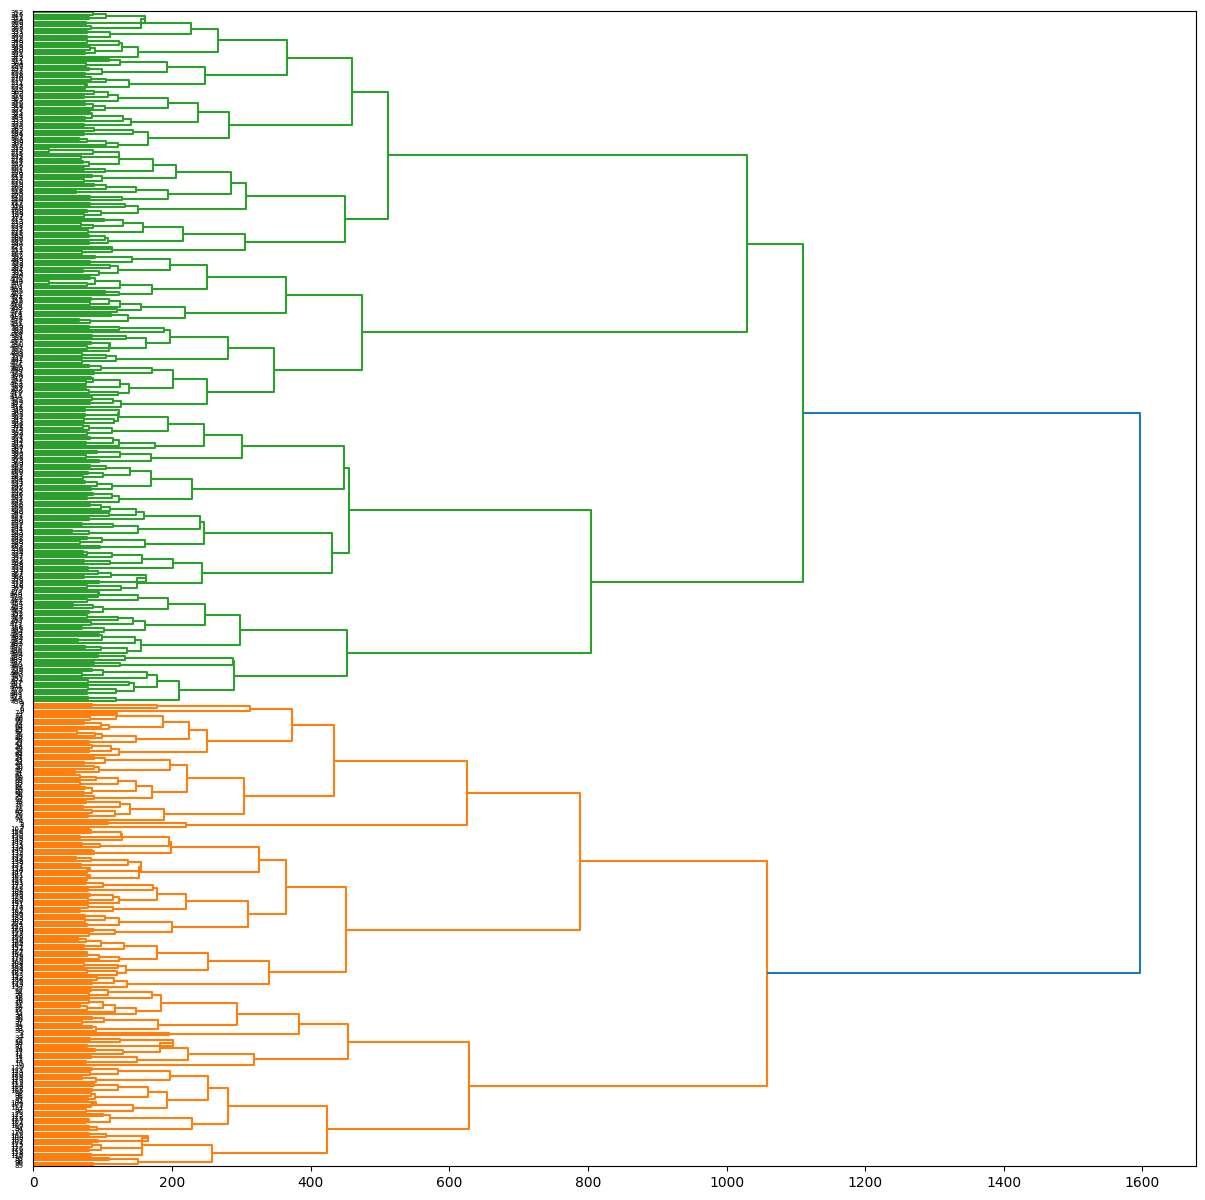

In [162]:
z = linkage(centres,method='centroid', metric='euclidean')
plt.figure(figsize=(15, 15))
dc = dendrogram(z, orientation='right')
plt.show()

Now that we have clustered the datapoints, let us take an arbitrary number of clusters (chosen with respect to the data given to us), in this case, we choose 7 and as we can see below, we have made 7 clusters which almost represent the different paragraphs in the passage as printed above.

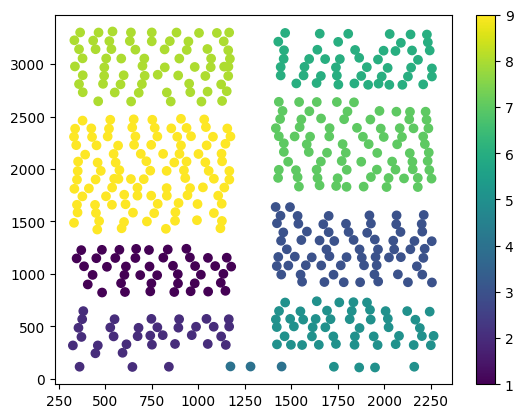

In [163]:
k = 9
df['cluster'] = fcluster(z, criterion='maxclust', t = k)
plt.scatter(centres[:, 0], centres[:, 1], c = df['cluster'])
plt.colorbar()
plt.show()

Now, that we have properly obtained which word belongs to which paragraph, we can assign each bounding box of a cluster its top, bottom, left and right boxes.

In [164]:
def get_top_box(df):
    min_distances = np.zeros((len(df), 2))
    min = 1e10
    idx = 0


    for i in range(len(df)):
        for j in range(len(df)):
            
            if df['cluster'][i] == df['cluster'][j] and i!=j:
                if df['Bottom'][j][1] > df['Top'][i][1]:
                    

                    dist = np.linalg.norm(np.array(df['Top'][i]) - np.array(df['Bottom'][j]))

                    if dist<min and dist != 0:
                        min = dist
                        idx = j

        if min != 1e10:
            min_distances[i, 0] = min
            min_distances[i, 1] = df['Id'][idx]
        else:
            min_distances[i, 0] = -1
            min_distances[i, 1] = 0
        min = 1e10
    
    return min_distances

def get_bottom_box(df):
    min_distances = np.zeros((len(df), 2))
    min = 1e10
    idx = 0


    for i in range(len(df)):
        for j in range(len(df)):
            
            if df['cluster'][i] == df['cluster'][j] and i!=j:
                if df['Top'][j][1] < df['Bottom'][i][1]:

                    dist = np.linalg.norm(np.array(df['Bottom'][i]) - np.array(df['Top'][j]))
                    
                    if dist<min and dist != 0:
                        min = dist
                        idx = j

        if min != 1e10:
            min_distances[i, 0] = min
            min_distances[i, 1] = df['Id'][idx]
        else:
            min_distances[i, 0] = -1
            min_distances[i, 1] = 0
        min = 1e10
    
    return min_distances

def get_right_box(df):
    min_distances = np.zeros((len(df), 2))
    min = 1e10
    idx = 0


    for i in range(len(df)):
        for j in range(len(df)):
            
            if df['cluster'][i] == df['cluster'][j] and i!=j:
                if df['Left'][j][0] > df['Right'][i][0]:

                    dist = np.linalg.norm(np.array(df['Right'][i]) - np.array(df['Left'][j]))

                    if dist<min and dist != 0:
                        min = dist
                        idx = j

        if min != 1e10:
            min_distances[i, 0] = min
            min_distances[i, 1] = df['Id'][idx]
        else:
            min_distances[i, 0] = -1
            min_distances[i, 1] = 0
        min = 1e10
    
    return min_distances

def get_left_box(df):
    min_distances = np.zeros((len(df), 2))
    min = 1e10
    idx = 0


    for i in range(len(df)):
        for j in range(len(df)):
            
            if df['cluster'][i] == df['cluster'][j] and i!=j:
                if df['Right'][j][0] < df['Left'][i][0]:

                    dist = np.linalg.norm(np.array(df['Left'][i]) - np.array(df['Right'][j]))

                    if dist<min and dist != 0:
                        min = dist
                        idx = j

        if min != 1e10:
            min_distances[i, 0] = min
            min_distances[i, 1] = df['Id'][idx]
        else:
            min_distances[i, 0] = -1
            min_distances[i, 1] = 0
        min = 1e10
    
    return min_distances



In [165]:
df['Top_Box'] = get_top_box(df).tolist()
df['Bottom_Box'] = get_bottom_box(df).tolist()
df['Right_Box'] = get_right_box (df).tolist()
df['Left_Box'] = get_left_box(df).tolist()

In [166]:
dfs = df.drop('cluster', axis = 1)
print(dfs.head())

   Unnamed: 0    Top-Left Bottom-Right  Id             Top           Bottom  \
0           0   [290, 85]   [435, 147]   0   [362.0, 85.0]   [362.0, 147.0]   
1           1   [563, 82]   [730, 147]   1   [646.0, 82.0]   [646.0, 147.0]   
2           2   [744, 92]   [940, 140]   2   [842.0, 92.0]   [842.0, 140.0]   
3           3  [1163, 92]  [1184, 147]   3  [1173.0, 92.0]  [1173.0, 147.0]   
4           4  [1218, 79]  [1344, 157]   4  [1281.0, 79.0]  [1281.0, 157.0]   

             Right             Left                     Top_Box  \
0   [435.0, 116.0]   [290.0, 116.0]  [212.72047386182646, 10.0]   
1   [730.0, 114.0]   [563.0, 114.0]   [204.40156555173445, 2.0]   
2   [940.0, 116.0]   [744.0, 116.0]    [203.5706265648362, 1.0]   
3  [1184.0, 119.0]  [1163.0, 119.0]   [126.05157674539419, 4.0]   
4  [1344.0, 118.0]  [1218.0, 118.0]   [127.62444906835053, 3.0]   

                  Bottom_Box                   Right_Box  \
0  [291.34343994674055, 1.0]   [128.01562404644207, 1.0]   
1 

Now that we have the dataframe consisting all the information of the required boxes to connect, we will now visualise this and obtain the final output.

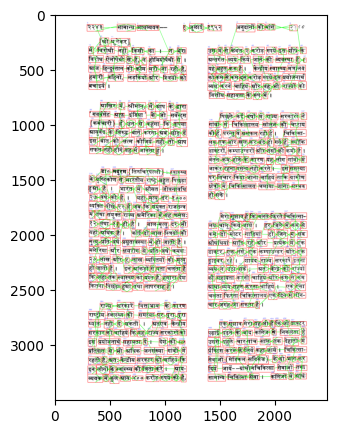

In [169]:
img = make_connections(img, dfs)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()